In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import ml_collections as mlc
import torch
from torch.autograd.functional import jacobian
import seaborn as sns

from Empirical.data import getLogRet
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, MaskedMSELoss
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC, trainMCMCMasked
from BasicAutoEncoder.Metric import CCACorr

from Andreini_data.data import load_y

(879, 116)


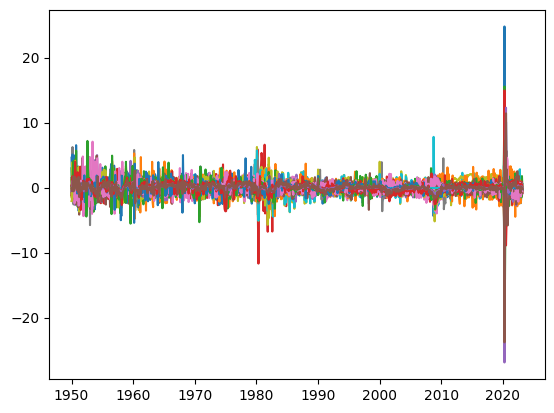

In [12]:

y, mask, index= load_y(daterange=['1950-01-01', '2024-01-01'])
y[np.isnan(y)] = 0
print(y.shape)
plt.plot(index,y);

(600, 116) (100, 116) (179, 116)


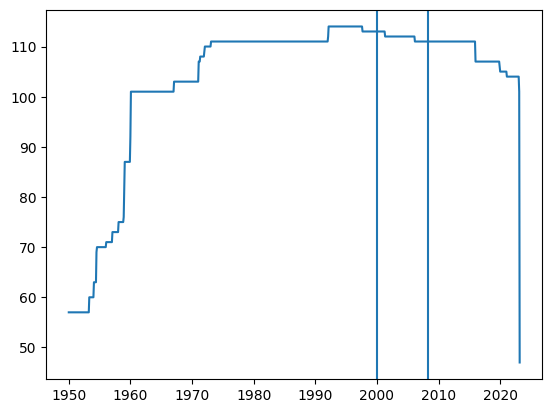

In [14]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 5
cfg.obs_dim = y.shape[1]
cfg.p_factor = 2
cfg.p_eps = 0
cfg.T_train = 600
cfg.T_test = 129
cfg.T_val = 100
cfg.T = y.shape[0] #529

#Training config
cfg.batch_size = 32
cfg.lr = 0.0001
cfg.n_epoch = 10
cfg.max_iter = 25


#Create train test val
y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]

weights_train = mask[0:cfg.T_train]
weights_val = mask[cfg.T_train:cfg.T_train+cfg.T_val]
print(y_train.shape, y_val.shape, y_test.shape)


plt.plot(index,mask.sum(axis=1))
plt.axvline(x=index[cfg.T_train])
plt.axvline(x=index[cfg.T_train+cfg.T_val])

In [142]:

cfg.lr = 0.01
cfg.max_iter = 10
cfg.n_epochs = 10
cfg.obs_dim = y_train.shape[1]
dec = Decoder(hidden_dim=[cfg.factor_dim, 20,80, cfg.obs_dim], activation=nn.Sigmoid(), lastLayerLinear=True)
enc = Encoder(hidden_dim=[cfg.obs_dim, 80,20, cfg.factor_dim], activation=nn.Sigmoid(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
#errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=1)
metrics = []
train_hist = trainMCMCMasked(X_train=y_train, X_val = y_val, weights_train=weights_train, weights_val=weights_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter=cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainable paramaters 22281
torch.Size([600, 116]) torch.Size([100, 116])
1 1.175401618606165886061658
2 0.3337549739762356697623566
3 0.3223052511089726110897265
4 0.3174169126309846563098465
5 0.3227260034335287343352876
6 0.3199366127189837271898375
7 0.3207949337206389372063897
8 0.3182685594809682748096827
9 0.3240504343258707432587075
10 0.322378891079049407904946


KeyboardInterrupt: 

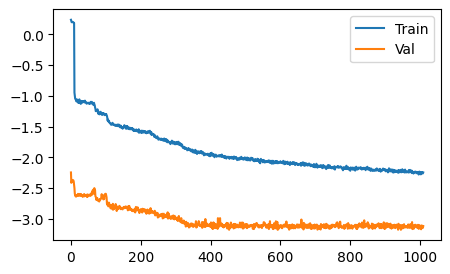

In [134]:
plot_train_hist(train_hist=train_hist, log=True)

In [153]:
plt.plot(np.diagerrorProcess.fit_hist['var']

[array([1.13749997, 1.00349022, 0.97726814, 1.08117979, 0.97132344,
        0.9587979 , 0.9751311 , 0.98844053, 0.99526109, 0.99115818,
        1.08762077, 1.01723933, 1.00433783, 1.02868884, 1.05819704,
        0.95170021, 1.1032305 , 1.03072599, 1.00718513, 0.98858792,
        0.89873735, 0.99159726, 1.01610733, 1.13801343, 1.01229387,
        1.02616572, 0.95193432, 0.98945535, 0.96994467, 1.03292634,
        1.05300588, 0.96163303, 1.04168016, 0.99196312, 1.0699806 ,
        0.94542738, 0.92781718, 0.98287264, 0.91231147, 1.04940031,
        0.99319419, 0.93161171, 0.93857064, 1.02106252, 0.94192215,
        0.92280131, 1.0425333 , 0.97840239, 0.91906458, 1.00071803,
        1.05632425, 0.97915256, 1.00161204, 1.07464758, 0.94335392,
        0.95878759, 0.96976768, 1.10513334, 1.01275154, 1.02669687,
        1.05242229, 0.91441816, 0.97003692, 1.01707751, 0.88115137,
        1.05566217, 0.97043343, 0.94944841, 0.97190677, 0.849167  ,
        1.03828658, 1.02186649, 1.03189522, 1.06

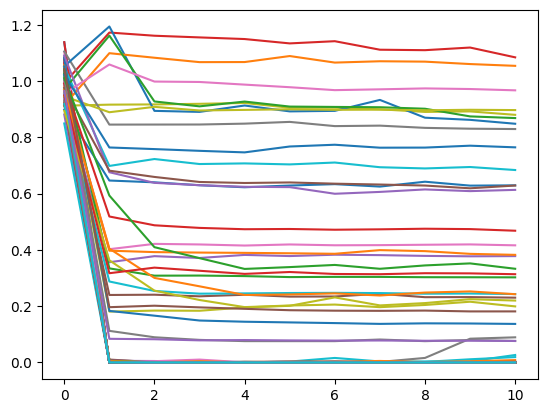

In [161]:
try:
    plt.plot([np.diag(_) for _ in errorProcess.fit_hist['cov']]);
    plt.figure()
    plt.plot(errorProcess.fit_hist['mu']);
except:
    None
try:
    plt.plot(errorProcess.fit_hist['var']);
except:
    None


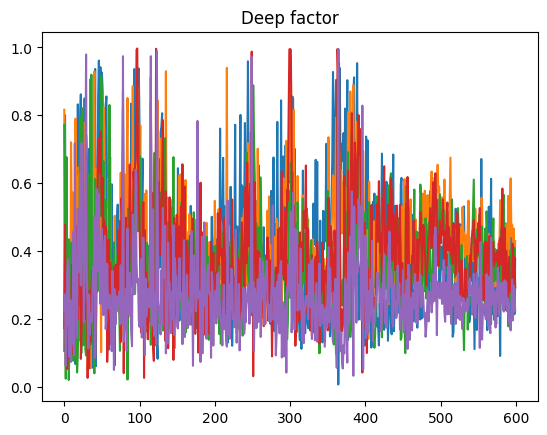

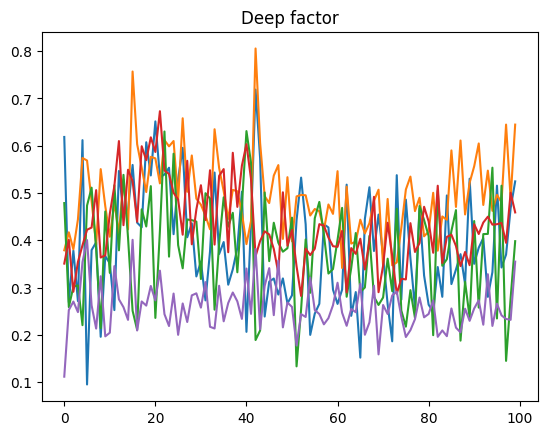

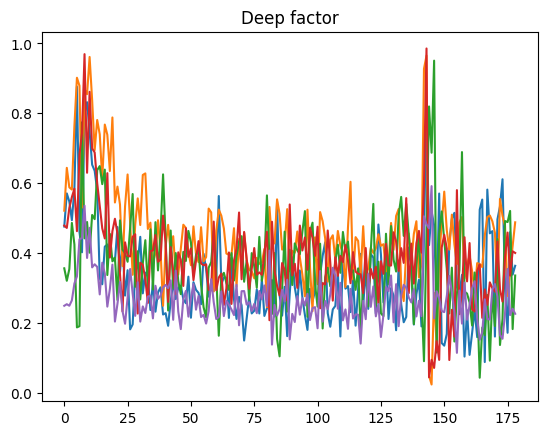

In [136]:
plot_factor_estimates(mod, y_train)
plt.figure();
plot_factor_estimates(mod, y_val)
plt.figure();
plot_factor_estimates(mod, y_test)

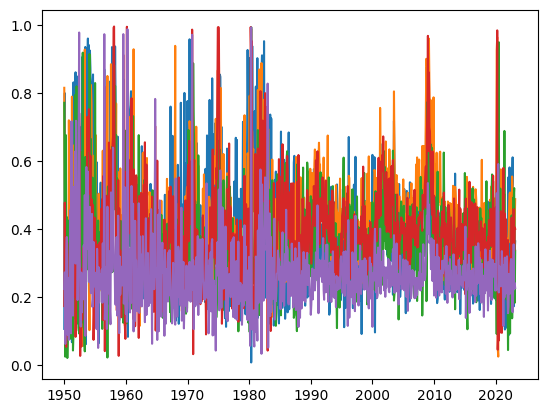

In [137]:
f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
plt.plot(index, f_hat);

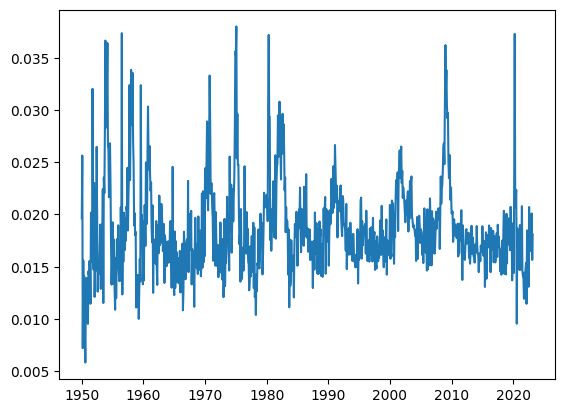

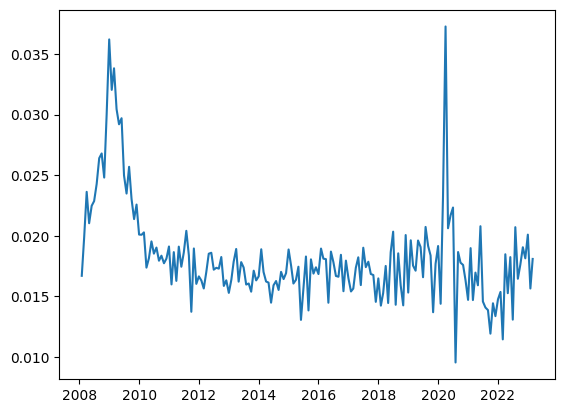

In [138]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    sum = 0
    fn = fobreniusNorm(F)
    for k in range(f.shape[1]):
        for i in range(F.shape[1]):
            sum += f[:,k] * (F[k,i]**2)/fn
    return sum

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
i = np.argwhere(index > '2008').min()
plt.plot(index[i:],CI[i:])

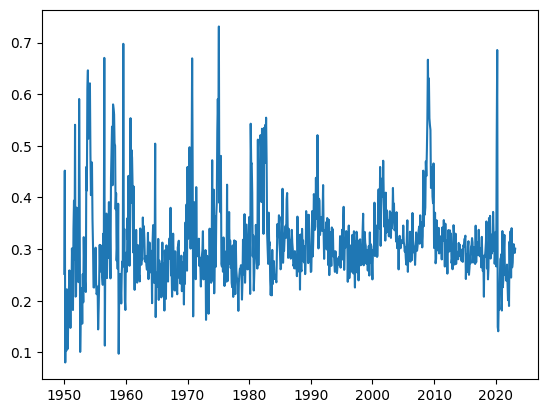

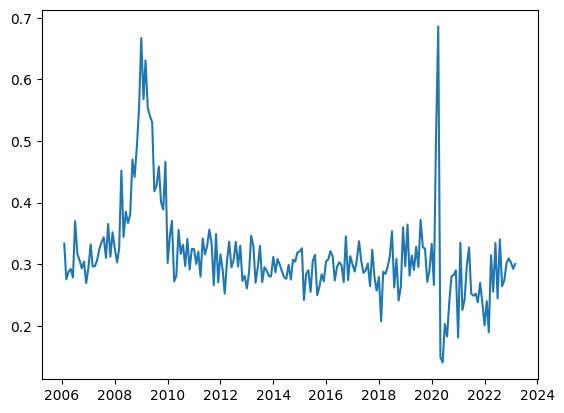

In [139]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    res = []
    for t in range(f.shape[0]):
        
        jac = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy().T
        sum = 0
        fn = fobreniusNorm(jac)
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (jac[k,i]**2)/fn
        res.append(sum)
    return np.array(res)

F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat)

plt.plot(index,CI)
plt.figure()
flip = False
i = np.argwhere(index > '2006').min()
plt.plot(index[i:],CI[i:] * (-1 if flip else 1))


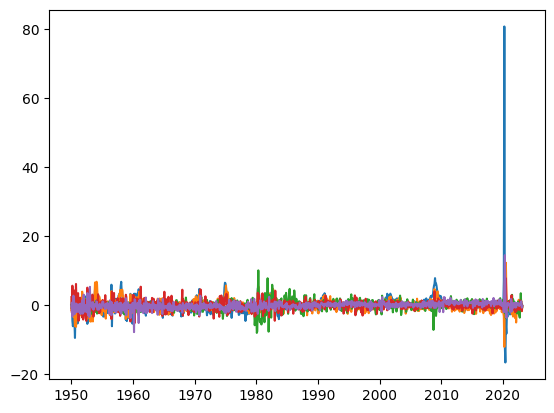

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=cfg.factor_dim)
f_hat_rotated = pca.fit_transform(y)
plt.plot(index,f_hat_rotated);

## Cast in statespace with EKF

In [108]:
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
varModel = VAR(np.concatenate([f_train_hat, f_val_hat]))
res = varModel.fit(maxlags=1, ic='aic')
y_hat = mod(torch.Tensor(y).float()).detach().numpy()
resid = y - y_hat
obs_cov = np.cov(resid.T)

In [88]:
print(np.mean((y_hat-y)**2))

0.14196041126199643


In [66]:
obs_cov.min()

-0.7323805181379379

In [65]:
errorProcess.cov.min()

-0.35179372763900774

<Axes: >

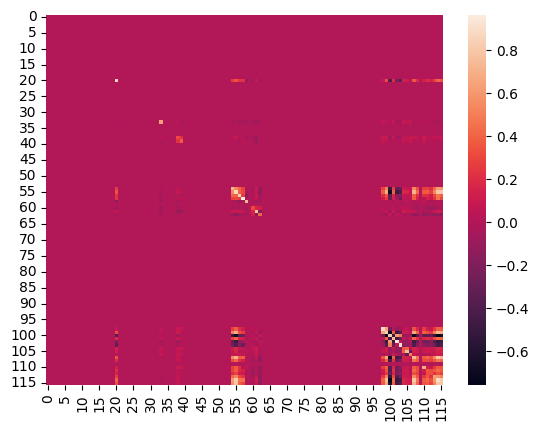

In [110]:
sns.heatmap(obs_cov)

True

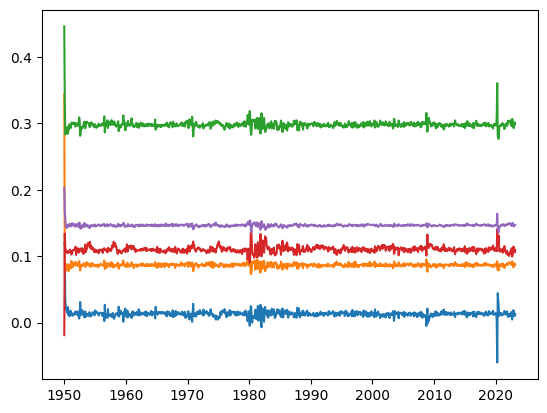

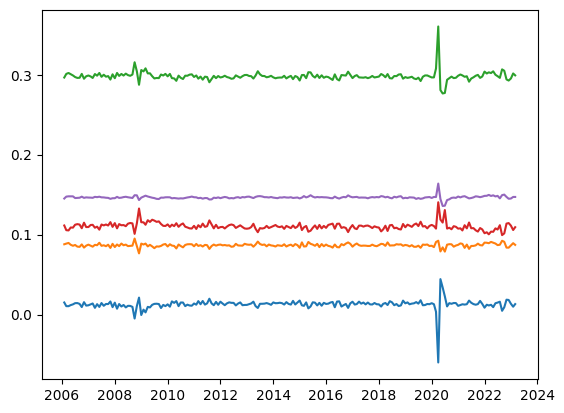

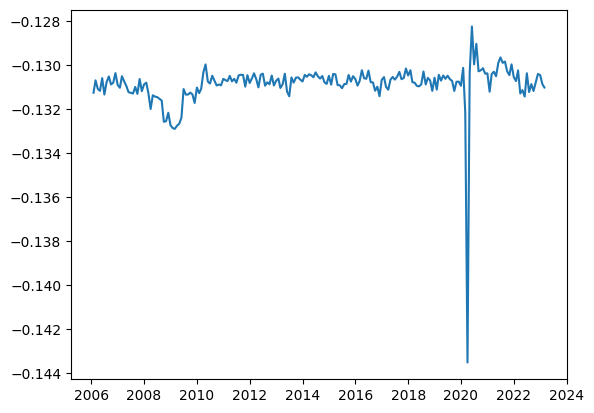

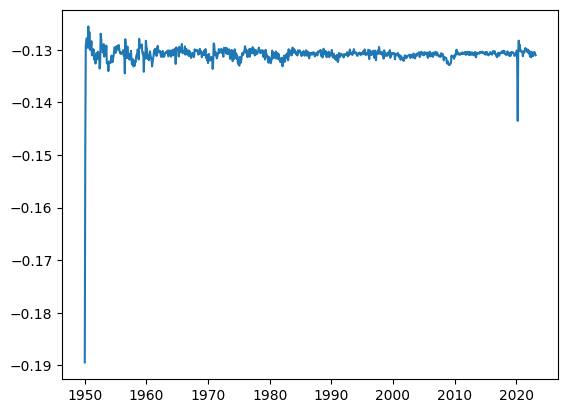

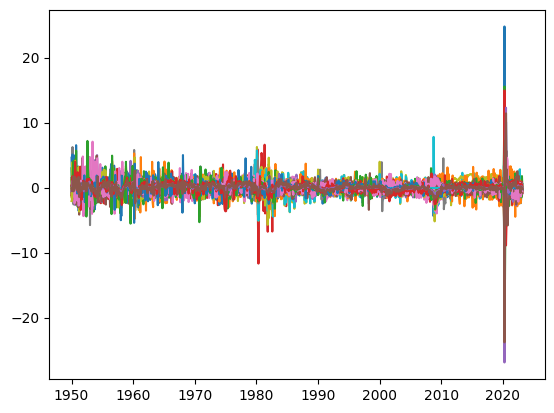

In [111]:
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilter
dim_x = cfg.factor_dim
dim_z = cfg.obs_dim
ekf = ExtendedKalmanFilter(dim_x, dim_z)
ekf.R = np.diag(np.diag(np.where(errorProcess.cov < 0, 0.0, errorProcess.cov)))
ekf.R = np.diag(np.diag(obs_cov))

#ekf.Q = res.sigma_u
ekf.F = res.params[:-1]
ekf.P = res.sigma_u
ekf.x = f_train_hat[-1]
decoder = mod.dec
Hx = lambda state: decoder(torch.Tensor(state).float()).detach().numpy()
HJacobian = lambda state: jacobian(decoder,torch.Tensor(state).float()).detach().numpy()
xs = []
zs = []
for i in range(y.shape[0]):
    z = y[i,:]
    ekf.update(z, HJacobian, Hx)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)
plt.plot(index, np.stack(xs));
plt.figure()
i = np.argwhere(index > '2006').min()
plt.plot(index[i:], np.stack(xs)[i:]);
plt.figure()
flip = True
CI_filtered = computeCI(F, np.stack(xs))
plt.plot(index[i:],CI_filtered[i:] * (-1 if flip else 1))
plt.figure()
plt.plot(index, CI_filtered * (-1 if flip else 1))
plt.figure()
plt.plot(index, np.stack(zs));
